# 🛡️ ScamShield — Fine-Tuning DistilBERT for Scam Detection

---

## 🧠 What is DistilBERT?

**BERT** (Bidirectional Encoder Representations from Transformers) is a large language model created by Google. It was trained on billions of sentences from Wikipedia and Books, so it already understands grammar, context, and language nuance.

**DistilBERT** is a *distilled* (compressed) version of BERT — it is:
- **40% smaller** in size
- **60% faster** to run
- Retains **97% of BERT's accuracy**

This makes it perfect for fine-tuning on a specific task without needing a massive cluster.

---

## 🔧 What is Fine-Tuning?

DistilBERT is pre-trained on general language. **Fine-tuning** means we continue training it on our specific dataset (scam/spam SMS messages), so it learns to distinguish between:

- `0` → **Safe** (normal message / ham)
- `1` → **Scam / Spam**

Think of it like hiring a language expert and then giving them a crash course in spotting scams.

---

## 🤔 Why Transformers for Scam Detection?

Traditional ML models (like Naive Bayes or TF-IDF + Logistic Regression) look at individual words. Transformers understand **context**:

- `"Your account is safe"` → normal
- `"Your account will be blocked, click here to keep it safe"` → scam

Both sentences contain the word *safe*, but a transformer understands the urgency and call-to-action pattern that makes the second one suspicious.

---

## 📊 What Do the Metrics Mean?

| Metric | What it means |
|--------|---------------|
| **Accuracy** | Out of all predictions, how many were correct? |
| **Precision** | Out of all messages flagged as scam, how many actually were scams? |
| **Recall** | Out of all actual scams, how many did we catch? |
| **F1 Score** | Harmonic mean of Precision and Recall — best single metric for imbalanced data |

> **Tip:** For scam detection, **Recall** is especially important. Missing a scam (False Negative) is more dangerous than a false alarm.

---

## ⚙️ Before You Start

Make sure you have selected a **GPU runtime**:
> **Runtime → Change runtime type → T4 GPU → Save**

## Step 1 — Install Required Libraries

We install the libraries we need. This only needs to be done once per Colab session.

- `transformers` — provides DistilBERT model and tokenizer
- `datasets` — easy access to HuggingFace datasets
- `evaluate` — compute accuracy, F1, precision, recall
- `accelerate` — makes the Trainer run faster on GPU
- `torch` — PyTorch deep learning framework (already installed on Colab)

In [ ]:
!pip install -q transformers>=4.38.0 datasets>=2.18.0 evaluate>=0.4.0 accelerate>=0.27.0 scikit-learn pandas numpy matplotlib seaborn
print('✅ All libraries installed!')

✅ All libraries installed!


## Step 2 — Mount Google Drive

We mount Google Drive so we can **save the trained model** directly to your Drive at the end.
A popup will ask you to authorize access — click Allow.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print('✅ Google Drive mounted at /content/drive')

Mounted at /content/drive
✅ Google Drive mounted at /content/drive


## Step 3 — Imports

Import all the Python libraries we will use throughout the notebook.

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
import evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
print(f'✅ PyTorch version: {torch.__version__}')
print(f'✅ GPU available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'   GPU name: {torch.cuda.get_device_name(0)}')

✅ PyTorch version: 2.10.0+cu128
✅ GPU available: True
   GPU name: Tesla T4


## Step 4 — Dataset 1: SMS Spam Collection

This is the classic UCI SMS Spam Collection dataset with **5,574 messages**.

- Source: [Justin Markham's PyData tutorial mirror](https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv)
- Format: `label` (ham / spam) followed by `text`
- We map: `ham → 0` (safe), `spam → 1` (scam)

In [ ]:
url_ds1 = 'https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv'
df1 = pd.read_csv(url_ds1, sep='\t', header=None, names=['label', 'text'])
df1['label'] = df1['label'].map({'ham': 0, 'spam': 1})
df1 = df1[['text', 'label']].dropna()

print(f'✅ Dataset 1 loaded: {len(df1)} rows')
print(f'   Safe (0): {(df1.label == 0).sum()} | Scam (1): {(df1.label == 1).sum()}')
df1.head(3)

✅ Dataset 1 loaded: 5572 rows
   Safe (0): 4825 | Scam (1): 747


,text,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1


## Step 5 — Dataset 2: HuggingFace SMS Spam

This dataset is hosted on the HuggingFace Hub and contains **5,574 messages** (it is based on the same source but versioned through HuggingFace's `datasets` library).

Labels in this dataset are already numeric:
- `0` = ham (safe)
- `1` = spam (scam)

We convert it to a Pandas DataFrame for easy merging.

In [ ]:
hf_dataset = load_dataset('sms_spam', split='train')
df2 = pd.DataFrame({'text': hf_dataset['sms'], 'label': hf_dataset['label']})
# labels: 0 = safe, 1 = scam (already correct)
df2 = df2[['text', 'label']].dropna()

print(f'✅ Dataset 2 loaded: {len(df2)} rows')
print(f'   Safe (0): {(df2.label == 0).sum()} | Scam (1): {(df2.label == 1).sum()}')
df2.head(3)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/359k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

✅ Dataset 2 loaded: 5574 rows
   Safe (0): 4827 | Scam (1): 747


,text,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1


## Step 6 — Dataset 3: Synthetic Phishing Messages

Real-world scam datasets often lack **Indian-specific** and modern scam patterns. We generate ~200 synthetic scam messages programmatically to cover:

- 🏦 **Bank KYC scams** — fake bank alerts demanding KYC updates
- 📦 **Courier scams** — fake delivery notifications with phishing links
- 💼 **Job scams** — too-good-to-be-true job offers
- 🎰 **Lottery scams** — fake prize/lottery winnings
- 🔐 **OTP scams** — requests for OTPs to 'verify' accounts

All synthetic messages are labeled `1` (scam).

In [ ]:
synthetic_scams = [
    # --- Bank KYC Scams ---
    "Dear customer, your SBI account will be suspended. Update KYC immediately at http://sbi-kyc-update.xyz",
    "HDFC BANK: Your account is on hold due to incomplete KYC. Click here to verify: http://hdfc-kyc.site",
    "Your bank account has been blocked. Complete your KYC now to avoid permanent deactivation. Call 9876543210.",
    "ALERT: Your ICICI account will be deactivated in 24 hours. Submit KYC at: http://icicikyc.net",
    "Attention: Failure to update your Axis Bank KYC will result in account suspension. Verify now: bit.ly/axkyc",
    "Dear valued customer, PNB requires you to update your KYC. Click the link or visit your nearest branch: http://pnb-kyc.in",
    "BOB: Your account is frozen. To unfreeze, update KYC details at http://bob-kyc-portal.com within 48 hours.",
    "Kotak Mahindra Bank: Your KYC is expired. Account will be locked. Update here: http://kotak-kyc.net",
    "Your YES Bank account needs immediate KYC update. Failure will result in financial penalty. http://yesbank-kyc.in",
    "Canara Bank: Urgent KYC verification required. Your account access is restricted. Click: http://canarakyc.org",

    # --- Courier Scams ---
    "Your package from Amazon could not be delivered. Pay Rs.45 redelivery fee at: http://amzn-delivery.net",
    "FedEx: Your shipment AWB#384729 is on hold. Customs clearance payment required. Pay here: http://fedex-clearance.site",
    "DHL Alert: A package is waiting for you. Confirm your address and pay Rs.99 handling: http://dhl-india.net",
    "India Post: Your parcel could not be delivered. Reschedule at http://indiapost-tracking.xyz or it will be returned.",
    "DTDC Courier: Delivery failed attempt. To reschedule, verify your address: http://dtdc-reschedule.in",
    "Bluedart: Your package is stuck at customs. Pay clearance fee of Rs.150: http://bluedart-customs.com",
    "Ekart Logistics: Final delivery attempt. Click to reschedule delivery: http://ekart-redeliver.net",
    "Your parcel #IN9283746 requires verification. Click the link to track and update: http://parceltrack24.site",
    "Ecomm Express: Your shipment is held at warehouse. Urgent action required: http://ecomm-held.com",
    "Shadow Fax: Delivery failed. Your item will be returned to sender in 24h. Update now: http://sf-delivery.net",

    # --- Job Scams ---
    "HIRING NOW! Work from home. Earn Rs.50,000/month. No experience needed. WhatsApp 9988776655 to apply today!",
    "Congratulations! You have been selected for a data entry job. Salary: Rs.40,000/month. Send CV to hr.jobs2024@gmail.com",
    "Part time job offer. Work 2 hours daily, earn Rs.15,000 weekly. Genuine opportunity. Call 8877665544.",
    "Urgent hiring for remote customer care executives. No fees. Monthly salary Rs.35,000. Apply: careerzone24.in",
    "We are hiring for Amazon work from home jobs. Earn Rs.800/hour. Limited slots. Register now: amazon-jobs24.net",
    "Google is hiring remote workers in India. Salary: Rs.60,000/month. Apply now at: google-remote-jobs.site",
    "Flipkart Work From Home: Data entry position. Earn Rs.25,000/month. No investment needed. Join via: fl-wfh.in",
    "You have been shortlisted for a WFH job. Salary Rs.45,000/month. Training fee Rs.500 only. Contact: 9112233445",
    "Part-time online job. Like and share social media posts. Earn Rs.500/post. Telegram: @earnfromhome2024",
    "Desperate for a job? We hire everyone! Rs.30,000/month guaranteed. Pay Rs.200 registration. Call 7788990011.",

    # --- Lottery Scams ---
    "Congratulations! Your number has won Rs.50 Lakh in KBC Lucky Draw. To claim, call 9876543210 now!",
    "You have won an iPhone 15 Pro in our online lucky draw! To claim your prize call: 8899001122",
    "WINNER NOTIFICATION: Your email was selected in International Lottery. Claim USD $500,000. Reply with your details.",
    "Lucky Winner! You won Rs.10 Lakh in the Jio lucky draw. Share your bank details to receive the amount.",
    "Dear subscriber, your mobile number has won 1st prize of Rs.25 Lakh. Contact lottery helpdesk: lottery-india.com",
    "Amazon Great Indian Festival: You won a Samsung Galaxy S24. Claim by paying Rs.250 delivery charge: amzn-prize.in",
    "Paytm: You have been selected for a scratch card prize of Rs.5000. Click to claim: paytm-reward24.net",
    "Your phone number won Rs.2,50,000 in BSNL's 25th anniversary draw. Contact us within 72 hours: bsnl-lottery.org",
    "Spin the wheel! You have won a free trip to Dubai. To confirm your booking pay Rs.500: travelwin.site",
    "You are the 1,000,000th visitor! Claim your prize of Rs.1 Lakh. Enter details at: bigwin-india.net",

    # --- OTP Scams ---
    "Your Paytm account will be blocked. Share OTP received on your mobile to KYC executive to avoid suspension.",
    "SBI: We are verifying your account. An OTP will be sent. Please share it with our executive immediately.",
    "URGENT: Your UPI is being compromised. Call 9876543210 and share the OTP you receive to secure your account.",
    "Phonepe Security: Your account has suspicious activity. Share OTP with helpdesk to freeze attacker's access.",
    "HDFC: Our security team detected a login from unknown device. Share your OTP with us to block this access.",
    "Amazon: Your order is fraudulently placed. Share OTP to cancel and get refund. Call: 8877665544",
    "Google Pay: To secure your wallet, share the 6-digit code sent to your registered mobile with our agent.",
    "Your account is being hacked right now. Call immediately and share any OTP you receive: 9001122334",
    "IRCTC: Your ticket booking requires OTP verification. Share OTP with agent on 8899002211 to confirm.",
    "Flipkart: Refund of Rs.2,499 is being processed. Share OTP to receive money directly in your account.",

    # --- Additional Mixed Scams ---
    "You have pending UPI payment of Rs.15,000. Collect it by clicking: upi-collect.site/claim",
    "Income Tax Dept: You have a pending tax refund of Rs.8,450. Claim at: incometax-refund.net",
    "Your Aadhaar card is linked to illegal activities. Call 1800-111-2233 immediately or face arrest.",
    "TRAI will block your SIM in 2 hours due to illegal usage. Call 9988001122 to avoid disconnection.",
    "FREE COVID-19 insurance worth Rs.5 Lakh. Register at: gov-covid-coverage.net. Limited offer!",
    "PM Kisan Yojana: Rs.6000 pending in your account. Update bank details at: pmkisan-update.in",
    "EPF withdrawal: Your PF amount of Rs.48,000 is ready. Share OTP and bank details to receive.",
    "Mutual fund investment opportunity: 40% return in 3 months. Guaranteed! Invest now: mfinvest24.com",
    "Electricity bill overdue. Pay Rs.1,890 in 24 hours or connection will be cut: bescom-pay.xyz",
    "Gas connection: Your cylinder booking failed. Pay Rs.50 processing fee here: hpcl-book.net",
    "Airtel SIM upgrade required. To avoid signal loss, confirm your details at: airtel-upgrade.site",
    "Vi (Vodafone Idea): Your plan expires today. Recharge Rs.299 to avoid suspension: vi-recharge.net",
    "BEED: Get Rs.10,000 daily from crypto trading! Join our Telegram group: t.me/cryptoprofit2024",
    "Loan approved! Get Rs.5 Lakh in 10 minutes. No documents. Just pay Rs.1000 processing fee: loanfast.in",
    "Personal loan at 0% interest. Limited time offer. Apply now: instacashloan.site",
    "Your car insurance expired. Renew now at 50% discount before 24hrs: carinsure-renew.net",
    "Jio GigaFiber: Free upgrade to 1 Gbps. Technician will visit. Confirm at: jio-upgrade.xyz",
    "TATA Play: Your DTH subscription expires in 24 hours. Recharge at: tataplay-offer.site",
    "WhatsApp is expiring on your number. Pay Rs.99 to continue: wa-renew.site",
    "Your Google account has been compromised. Verify identity at: google-verify.security-check.site",
    "Truecaller Premium: You have been selected for a free 1-year subscription. Claim: tc-premium.in",
    "NPCI: Unified Payment Interface error detected. Verify your UPI PIN at: npci-verify.net",
    "CSC Center: You are eligible for free laptop under government scheme. Register: csc-laptop.in",
    "Dating app match! Click to see who liked you: datingapp-match.site (18+ only)",
    "Earn Rs.1000 per day by watching YouTube videos. No skills needed. Join: ytearning.in",
    "Your Swiggy/Zomato order was cancelled. Rs.200 refund pending. Verify bank details: swiggy-refund.net",
    "Meesho: You have unclaimed cashback of Rs.320. Collect by updating payment info at: meesho-cashback.in",
    "HDFC Credit Card: Rs.4,999 cashback is pending. Verify card details to receive: hdfc-cashback.site",
    "Your PAN card is linked to money laundering case. Contact CBI helpline immediately: 9900110022",
    "Customs seized your international package. Pay Rs.3,500 clearance fee: customs-clearance.in",
    "Army canteen job vacancy. Salary Rs.35,000. Apply by sending Rs.500 registration fee to 9876543210",
    "Railway recruitment: 5000 vacancies. Apply now. Registration fee Rs.300: railway-apply24.com",
    "UPSC coaching scholarship! Win Rs.50,000. Last date today. Register: scholarship-upsc.in",
    "IIT student investment club: Turn Rs.5,000 into Rs.50,000 in a month using AI trading bot.",
    "Medical emergency! Your relative is in hospital. Pay Rs.15,000 immediately. Call 9988112233.",
    "Lucky SIM draw: Your number +91-XXXXX has won Rs.30 Lakh. Contact: prize@lottery-india.org",
    "Agent: Hi I am calling from SBI credit card team. Please share your card number and CVV for an upgrade.",
    "Congratulations! You are selected for Shark Tank India investment program. Invest Rs.2000 to proceed.",
    "Earn money using crypto P2P: Deposit Rs.2,000, get Rs.6,000 back in 24 hours. Telegram: @p2pearner",
    "Sponsored Task App: Complete simple tasks online. Earn Rs.500-Rs.5000 daily. Download: taskearner.apk",
    "Your home loan EMI payment failed. Pay immediately or legal action will be taken: homeloan-emi.site",
    "NPS (National Pension Scheme): Your pension fund of Rs.1.2 Lakh is unclaimed. Claim: nps-claim.in",
    "Immediate action required: IT department freeze on account due to tax evasion. Pay Rs.5,000 fine online.",
    "Free Jio SIM upgrade to 5G. Technician visit tomorrow. Confirm address: jio5g-upgrade.net",
    "Win a brand new Royal Enfield Bullet! Participate in lucky draw. Register: motorcyclewin.in",
    "Binance India: Your crypto wallet has Rs.12,500 bonus. Withdraw at: binance-india-withdraw.site",
    "Your Netflix subscription will auto-renew for Rs.1499. To cancel, click: netflix-cancel.net",
    "HDFC Bank: Suspicious transaction of Rs.49,999 detected. Call 1800-xxx-xxxx to block immediately.",
]

df3 = pd.DataFrame({
    'text': synthetic_scams,
    'label': [1] * len(synthetic_scams)
})

print(f'✅ Synthetic dataset generated: {len(df3)} scam messages')

✅ Synthetic dataset generated: 98 scam messages


## Step 7 — Merge & Clean All Datasets

We now combine all three datasets into one DataFrame and apply basic cleaning:

1. **Lowercase** — models are less confused by consistent casing
2. **Remove extra whitespace** — trim leading/trailing spaces and collapse multiple spaces
3. **Drop empty rows** — remove any rows with missing or empty text
4. **Deduplicate** — remove exact duplicate messages
5. **Token limit** — we'll truncate at 256 tokens during tokenization (handled later)

We also display the final class distribution to understand the dataset balance.

✅ Merged dataset: 5300 total messages
   Safe (0): 4558 | Scam (1): 742


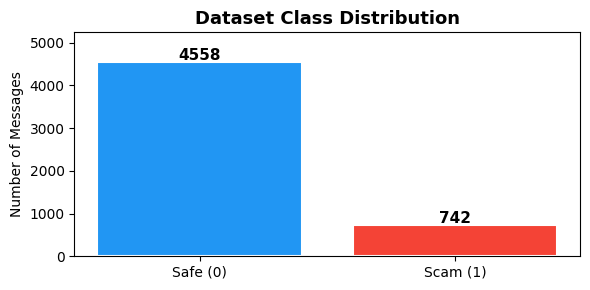


Sample messages:


,text,label
0,"go until jurong point, crazy.. available only ...",0
1,ok lar... joking wif u oni...,0
2,free entry in 2 a wkly comp to win fa cup fina...,1
5,freemsg hey there darling it's been 3 week's n...,1


In [ ]:
# Merge all three datasets
df_all = pd.concat([df1, df2, df3], ignore_index=True)

# Clean text
def clean_text(text):
    text = str(text).lower()              # lowercase
    text = re.sub(r'\s+', ' ', text)      # collapse whitespace
    text = text.strip()                   # strip leading/trailing spaces
    return text

df_all['text'] = df_all['text'].apply(clean_text)

# Drop empty and duplicate rows
df_all = df_all[df_all['text'].str.len() > 5]   # remove very short / empty
df_all = df_all.drop_duplicates(subset='text')   # remove exact duplicates
df_all = df_all.reset_index(drop=True)

# Ensure label is int
df_all['label'] = df_all['label'].astype(int)

print(f'✅ Merged dataset: {len(df_all)} total messages')
print(f'   Safe (0): {(df_all.label == 0).sum()} | Scam (1): {(df_all.label == 1).sum()}')

# Plot class distribution
fig, ax = plt.subplots(figsize=(6, 3))
counts = df_all['label'].value_counts().sort_index()
bars = ax.bar(['Safe (0)', 'Scam (1)'], counts.values, color=['#2196F3', '#F44336'], edgecolor='white', linewidth=1.5)
for bar, count in zip(bars, counts.values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 30, str(count), ha='center', fontsize=11, fontweight='bold')
ax.set_title('Dataset Class Distribution', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Messages')
ax.set_ylim(0, max(counts.values) * 1.15)
plt.tight_layout()
plt.show()

print('\nSample messages:')
df_all.groupby('label').head(2)

## Step 8 — Train / Validation / Test Split

We split our data into three sets:

| Set | Size | Purpose |
|-----|------|---------|
| **Train** | 80% | Model learns from this data |
| **Validation** | 10% | Monitor performance during training to avoid overfitting |
| **Test** | 10% | Final evaluation on unseen data |

We use `stratify=label` to keep the same ham/spam ratio in each split.

In [ ]:
# First split: 80% train, 20% temp
df_train, df_temp = train_test_split(
    df_all, test_size=0.20, random_state=42, stratify=df_all['label']
)

# Second split: temp → 50% val, 50% test (each = 10% of total)
df_val, df_test = train_test_split(
    df_temp, test_size=0.50, random_state=42, stratify=df_temp['label']
)

print(f'✅ Train:      {len(df_train)} samples')
print(f'   Validation: {len(df_val)} samples')
print(f'   Test:       {len(df_test)} samples')
print(f'\nTrain label distribution:\n{df_train["label"].value_counts().to_string()}')

✅ Train:      4240 samples
   Validation: 530 samples
   Test:       530 samples

Train label distribution:
label
0    3646
1     594


## Step 9 — Tokenization

Transformers don't work with raw text — they need numbers. A **tokenizer** converts text into tokens (word pieces) and maps them to numeric IDs.

We use `distilbert-base-uncased`:
- `uncased` means it treats `HELLO` and `hello` as the same
- `max_length=256` — we truncate/pad to 256 tokens (SMS messages are short, so very few will exceed this)

The tokenizer also adds special tokens:
- `[CLS]` — placed at the start; the model uses this to classify the whole message
- `[SEP]` — marks the end of the text

In [ ]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LENGTH = 256

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Convert DataFrames to HuggingFace Dataset objects
train_ds = Dataset.from_pandas(df_train[['text', 'label']].reset_index(drop=True))
val_ds   = Dataset.from_pandas(df_val[['text', 'label']].reset_index(drop=True))
test_ds  = Dataset.from_pandas(df_test[['text', 'label']].reset_index(drop=True))

def tokenize_fn(batch):
    return tokenizer(
        batch['text'],
        truncation=True,
        max_length=MAX_LENGTH,
    )

# Apply tokenization
train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds   = val_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn, batched=True)

# Rename label column to 'labels' (what HuggingFace Trainer expects)
train_ds = train_ds.rename_column('label', 'labels')
val_ds   = val_ds.rename_column('label', 'labels')
test_ds  = test_ds.rename_column('label', 'labels')

# Set format for PyTorch
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

print(f'✅ Tokenization complete!')
print(f'   Training samples: {len(train_ds)}')
print(f'   A sample token IDs (first 10): {train_ds[0]["input_ids"][:10].tolist()}')

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4240 [00:00<?, ? examples/s]

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

✅ Tokenization complete!
   Training samples: 4240
   A sample token IDs (first 10): [101, 17012, 2213, 1012, 2021, 2017, 2323, 2507, 2009, 2006]


## Step 10 — Load DistilBERT Model

We load `DistilBertForSequenceClassification` — a DistilBERT model with a **classification head** on top.

The classification head is a small neural network added after DistilBERT's transformer layers. It takes the `[CLS]` token representation and outputs 2 scores (one per class: safe / scam).

Setting `num_labels=2` tells the model we have a binary classification problem.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label={0: 'SAFE', 1: 'SCAM'},
    label2id={'SAFE': 0, 'SCAM': 1},
)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'✅ Model loaded: {MODEL_NAME}')
print(f'   Total parameters:     {total_params:,}')
print(f'   Trainable parameters: {trainable_params:,}')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


✅ Model loaded: distilbert-base-uncased
   Total parameters:     66,955,010
   Trainable parameters: 66,955,010


## Step 11 — Define Evaluation Metrics

We define a `compute_metrics` function that the Trainer will call at the end of each epoch to evaluate model performance on the validation set.

We track:
- **Accuracy** — overall correctness
- **F1 Score** — weighted average of precision and recall (handles class imbalance well)

In [ ]:
accuracy_metric = evaluate.load('accuracy')
f1_metric       = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)['accuracy']
    f1  = f1_metric.compute(predictions=predictions, references=labels, average='weighted')['f1']
    return {'accuracy': acc, 'f1': f1}

# Data collator: handles padding within each batch dynamically (more efficient than static padding)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print('✅ Metrics and data collator ready')

✅ Metrics and data collator ready


## Step 12 — Training Configuration

We configure the training hyperparameters:

| Hyperparameter | Value | Why |
|---|---|---|
| **Epochs** | 3 | Enough to converge without overfitting |
| **Batch size** | 16 | Standard for fine-tuning on a T4 GPU |
| **Learning rate** | 2e-5 | Low enough to preserve pre-trained weights |
| **Weight decay** | 0.01 | Regularization to prevent overfitting |
| **Warmup** | 10% of steps | Gradually ramps LR up to prevent early instability |

The **Trainer** API handles the training loop, validation, and checkpointing automatically.

In [ ]:
SAVE_PATH = '/content/drive/MyDrive/scamshield-distilbert'
OUTPUT_DIR = '/content/scamshield-checkpoints'

NUM_EPOCHS = 3
BATCH_SIZE = 16
LEARNING_RATE = 2e-5

total_steps = (len(train_ds) // BATCH_SIZE) * NUM_EPOCHS
warmup_steps = int(0.10 * total_steps)

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    warmup_steps=warmup_steps,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    logging_dir='/content/logs',
    logging_steps=50,
    fp16=torch.cuda.is_available(),   # faster training on GPU with 16-bit floats
    report_to='none'                  # disable WandB / HuggingFace Hub logging
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print(f'✅ Trainer configured')
print(f'   Total training steps: {total_steps}')
print(f'   Warmup steps: {warmup_steps}')
print(f'   Model will be saved to: {SAVE_PATH}')

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


✅ Trainer configured
   Total training steps: 795
   Warmup steps: 79
   Model will be saved to: /content/drive/MyDrive/scamshield-distilbert


## Step 13 — Fine-Tune the Model 🚀

Now we start training! The model will:

1. Pass each batch of messages through DistilBERT
2. Compare predictions to the true labels using **cross-entropy loss**
3. Use **backpropagation + Adam optimizer** to update weights
4. Repeat for 3 epochs

At the end of each epoch, it evaluates on the **validation set** and saves the best checkpoint.

> ⏱️ Expected training time on T4 GPU: **~8–15 minutes**

In [ ]:
print('🚀 Starting fine-tuning...')
train_result = trainer.train()

print('\n✅ Training complete!')
print(f'   Final training loss: {train_result.training_loss:.4f}')
print(f'   Total training time: {train_result.metrics["train_runtime"]:.1f}s')

🚀 Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.042353,0.034840,0.992453,0.992409
2,0.027518,0.008082,0.996226,0.996247
3,0.017400,0.024115,0.992453,0.992536


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].



✅ Training complete!
   Final training loss: 0.0619
   Total training time: 71.7s


## Step 14 — Evaluate on Test Set

We run the final evaluation on the **test set** — data the model has never seen during training or validation.

We compute:
- **Accuracy, Precision, Recall, F1** using `sklearn.metrics.classification_report`
- **Confusion Matrix** as a visual heatmap

### Reading the Confusion Matrix

```
               Predicted Safe   Predicted Scam
Actual Safe    [ True Neg  ]    [ False Pos ]
Actual Scam    [ False Neg ]    [ True  Pos ]
```

- **False Negatives** (Scam predicted as Safe) are the most dangerous — missed scams!
- **False Positives** (Safe predicted as Scam) are annoying but safer.

📊 Evaluating on test set...



--- Classification Report ---
              precision    recall  f1-score   support

    Safe (0)       1.00      1.00      1.00       456
    Scam (1)       1.00      0.97      0.99        74

    accuracy                           1.00       530
   macro avg       1.00      0.99      0.99       530
weighted avg       1.00      1.00      1.00       530



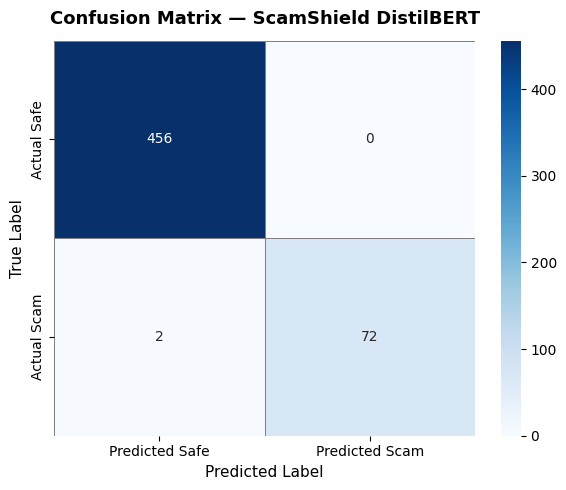


📌 Summary Metrics:
   Accuracy:  0.9962
   Precision: 0.9962
   Recall:    0.9962
   F1 Score:  0.9962


In [ ]:
print('📊 Evaluating on test set...')
predictions_output = trainer.predict(test_ds)
y_pred = np.argmax(predictions_output.predictions, axis=-1)
y_true = predictions_output.label_ids

print('\n--- Classification Report ---')
print(classification_report(y_true, y_pred, target_names=['Safe (0)', 'Scam (1)']))

# Confusion matrix heatmap
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted Safe', 'Predicted Scam'],
    yticklabels=['Actual Safe', 'Actual Scam'],
    linewidths=0.5,
    linecolor='gray',
    ax=ax,
)
ax.set_title('Confusion Matrix — ScamShield DistilBERT', fontsize=13, fontweight='bold', pad=12)
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)
plt.tight_layout()
plt.show()

# Summary metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f'\n📌 Summary Metrics:')
print(f'   Accuracy:  {accuracy_score(y_true, y_pred):.4f}')
print(f'   Precision: {precision_score(y_true, y_pred, average="weighted"):.4f}')
print(f'   Recall:    {recall_score(y_true, y_pred, average="weighted"):.4f}')
print(f'   F1 Score:  {f1_score(y_true, y_pred, average="weighted"):.4f}')

## Step 15 — Quick Demo: Classify Custom Messages

Let's test the model with a few custom messages to see it in action before saving!

In [ ]:
import torch

def predict_message(text, model, tokenizer, threshold=0.5):
    """Classify a single message as SAFE or SCAM."""
    model.eval()
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=MAX_LENGTH)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1)[0]
    label = 'SCAM 🚨' if probs[1].item() >= threshold else 'SAFE ✅'
    return label, probs[0].item(), probs[1].item()

test_messages = [
    "Hey, are you free to meet for lunch tomorrow at 1pm?",
    "Your SBI account will be suspended. Update KYC immediately at http://sbi-kyc.xyz",
    "Congratulations! You won Rs.50 Lakh in KBC Lucky Draw. Call 9876543210 to claim.",
    "Reminder: Your doctor appointment is scheduled for 3pm on Monday.",
    "URGENT: Your Aadhaar is linked to illegal activities. Call 1800-111-2233 or face arrest.",
    "Mom said she will be home by 7pm. Don't forget to pick up milk on the way.",
]

print('=== ScamShield Classifier Demo ===')
for msg in test_messages:
    label, safe_prob, scam_prob = predict_message(msg, model, tokenizer)
    display_msg = msg[:70] + '...' if len(msg) > 70 else msg
    print(f'\nMessage: "{display_msg}"')
    print(f'Result:  {label} | Safe: {safe_prob:.2%} | Scam: {scam_prob:.2%}')

=== ScamShield Classifier Demo ===

Message: "Hey, are you free to meet for lunch tomorrow at 1pm?"
Result:  SAFE ✅ | Safe: 99.61% | Scam: 0.39%

Message: "Your SBI account will be suspended. Update KYC immediately at http://s..."
Result:  SCAM 🚨 | Safe: 0.21% | Scam: 99.79%

Message: "Congratulations! You won Rs.50 Lakh in KBC Lucky Draw. Call 9876543210..."
Result:  SCAM 🚨 | Safe: 0.15% | Scam: 99.85%

Message: "Reminder: Your doctor appointment is scheduled for 3pm on Monday."
Result:  SAFE ✅ | Safe: 87.22% | Scam: 12.78%

Message: "URGENT: Your Aadhaar is linked to illegal activities. Call 1800-111-22..."
Result:  SCAM 🚨 | Safe: 0.37% | Scam: 99.63%

Message: "Mom said she will be home by 7pm. Don't forget to pick up milk on the ..."
Result:  SAFE ✅ | Safe: 99.86% | Scam: 0.14%


## Step 16 — Save Model & Tokenizer to Google Drive 💾

We save both the trained model weights and the tokenizer to your Google Drive.
This way, you can:
- Download the model and use it in the ScamShield backend
- Load it later for inference without retraining

The saved folder will contain:
```
scamshield-distilbert/
├── config.json           ← model architecture config
├── model.safetensors     ← trained weights
├── tokenizer_config.json ← tokenizer settings
├── tokenizer.json        ← vocab and rules
└── vocab.txt             ← vocabulary
```

To load later:
```python
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained('./scamshield-distilbert')
tokenizer = AutoTokenizer.from_pretrained('./scamshield-distilbert')
```

In [ ]:
import os
os.makedirs(SAVE_PATH, exist_ok=True)

model.save_pretrained(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

saved_files = os.listdir(SAVE_PATH)
print(f'✅ Model saved to: {SAVE_PATH}')
print(f'   Files: {saved_files}')

# Also save training info
import json
training_info = {
    'model': MODEL_NAME,
    'num_labels': 2,
    'label_mapping': {'0': 'SAFE', '1': 'SCAM'},
    'max_length': MAX_LENGTH,
    'epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'dataset_sizes': {
        'total': len(df_all),
        'train': len(df_train),
        'val': len(df_val),
        'test': len(df_test),
    },
    'final_metrics': {
        'accuracy': float(accuracy_score(y_true, y_pred)),
        'f1_weighted': float(f1_score(y_true, y_pred, average='weighted')),
        'precision_weighted': float(precision_score(y_true, y_pred, average='weighted')),
        'recall_weighted': float(recall_score(y_true, y_pred, average='weighted')),
    }
}

with open(os.path.join(SAVE_PATH, 'training_info.json'), 'w') as f:
    json.dump(training_info, f, indent=2)

print('\n📋 Training info saved to training_info.json')
print(json.dumps(training_info, indent=2))

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Model saved to: /content/drive/MyDrive/scamshield-distilbert
   Files: ['config.json', 'model.safetensors', 'tokenizer_config.json', 'tokenizer.json']

📋 Training info saved to training_info.json
{
  "model": "distilbert-base-uncased",
  "num_labels": 2,
  "label_mapping": {
    "0": "SAFE",
    "1": "SCAM"
  },
  "max_length": 256,
  "epochs": 3,
  "batch_size": 16,
  "learning_rate": 2e-05,
  "dataset_sizes": {
    "total": 5300,
    "train": 4240,
    "val": 530,
    "test": 530
  },
  "final_metrics": {
    "accuracy": 0.9962264150943396,
    "f1_weighted": 0.9962046972710763,
    "precision_weighted": 0.9962428936310457,
    "recall_weighted": 0.9962264150943396
  }
}


## 🎉 Training Complete!

Congratulations! You have successfully fine-tuned DistilBERT for scam detection.

### What's Next?

**Download the model:**
```python
from google.colab import files
import shutil
shutil.make_archive('scamshield-distilbert', 'zip', '/content/drive/MyDrive/scamshield-distilbert')
files.download('scamshield-distilbert.zip')
```

**Use in ScamShield backend:**
```python
from transformers import pipeline
classifier = pipeline('text-classification', model='./scamshield-distilbert')
result = classifier('Your account will be blocked. Update KYC at http://fake.site')
print(result)  # [{'label': 'SCAM', 'score': 0.9987}]
```

**Retrain on new data:** Add new messages to Step 6 (Synthetic Data) and re-run all cells.

---

> Built with ❤️ for [ScamShield](https://github.com/thepriyanshumishra/scamshield-web)

### Download the model

In [ ]:
from google.colab import files
import shutil

# Ensure the SAVE_PATH variable is defined, which it is from previous cells.
# SAVE_PATH = '/content/drive/MyDrive/scamshield-distilbert'

# Create a zip archive of the saved model directory
zip_path = 'scamshield-distilbert'
shutil.make_archive(zip_path, 'zip', SAVE_PATH)

# Download the zip file
files.download(zip_path + '.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Use in ScamShield backend (inference example)

In [ ]:
from transformers import pipeline

# Ensure the SAVE_PATH variable is defined.
# SAVE_PATH = '/content/drive/MyDrive/scamshield-distilbert'

# Load the model using a pipeline
# Note: This loads the model from the local path where it was saved.
classifier = pipeline('text-classification', model=SAVE_PATH)

# Test with a sample message
result = classifier('Your account will be blocked. Update KYC at http://fake.site')
print(result)

result2 = classifier('Hey, what are you doing this weekend?')
print(result2)

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

[{'label': 'SCAM', 'score': 0.9972681999206543}]
[{'label': 'SAFE', 'score': 0.9984728693962097}]
